
## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

---
### Objective

Objective is to develop an algorithm that can be used as mobile or web app. 
App will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of finished project. 

![Sample Dog Output](images/sample_dog_output.png)

There are basically 2 seperate algorithm that work together, human detector and CNN classifier.


### The Road Ahead

Notebook is broken into below separate steps.  

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, I import a dataset of dog images.  I populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, I import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, I demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


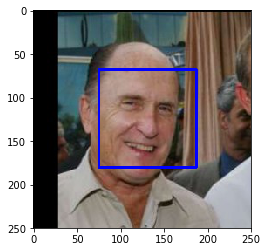

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

I can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

I used the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, I would like 100% of human images with a detected face and 0% of dog images with a detected face.  I can see that our algorithm falls short of this goal, but still gives acceptable performance.  I extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.



In [61]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

fd_human = [face_detector(fname) for fname in human_files_short]
percentage_human = 100*sum([f>0 for f in fd_human])/len(fd_human)
print(percentage_human,'% of the first 100 images in human_files had a human face detected in them.')
    
fd_dog = [face_detector(fname) for fname in dog_files_short]
percentage_dog = 100*sum([f>0 for f in fd_dog])/len(fd_dog)
print(percentage_dog,'% of the first 100 images in dog_files had a human face detected in them.')

100.0 % of the first 100 images in human_files had a human face detected in them.
11.0 % of the first 100 images in dog_files had a human face detected in them.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  My first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which I will refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since these are color images, each image has three channels.  Likewise, since I am processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that I have a way to format our image for supplying to ResNet-50, I am now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which I can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

I used the code cell below to test the performance of my `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?


In [59]:

### on the images in human_files_short and dog_files_short.

dd_human = [dog_detector(fname) for fname in human_files_short]
dpercentage_human = 100*sum([f>0 for f in dd_human])/len(dd_human)
print(dpercentage_human,'% of the first 100 images in human_files had a dog detected in them.')
    
dd_dog = [dog_detector(fname) for fname in dog_files_short]
dpercentage_dog = 100*sum([f>0 for f in dd_dog])/len(dd_dog)
print(dpercentage_dog,'% of the first 100 images in dog_files had a dog detected in them.')

0.0 % of the first 100 images in human_files had a dog detected in them.
100.0 % of the first 100 images in dog_files had a dog detected in them.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds

Now that I have functions for detecting humans and dogs in images, I need a way to predict breed from images.  In this step,I have created a CNN that classifies dog breeds. Here I am not using transfer learning. So my accuracy will be very low. In Step 5 of this notebook, I will use transfer learning to create a CNN that attains greatly improved accuracy.


The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  My vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">


### Pre-process the Data

I rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:13<00:00, 63.36it/s]


### Model Architecture

           
Why I choose this model!!!.



I decided to use the architecture below because I thought that using a series of convolutional layers with increasing filter size would allow the network to pick up increasingly complex patterns in the distinctions between the dog breeds (which is difficult to do with the naked eye). I also reasoned that having a pooling layer between each convolutional layer would increase the training efficiency of our model. I did decrease the number of filters in each convolutional layer because my intuition is that simpler models seem to perform better than more complex ones.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3))) # shape = 224 X 224 X 3 , Depth is 3 because color image R, G, B

model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=(110, 110, 3))) 

model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=(54, 54, 3))) 

model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D(input_shape=(27, 27, 64)))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 192s - loss: 4.8838 - acc: 0.0097 - val_loss: 4.8692 - val_acc: 0.0108
Epoch 2/10
6680/6680 [==============================] - 187s - loss: 4.8625 - acc: 0.0127 - val_loss: 4.8439 - val_acc: 0.0168
Epoch 3/10
6680/6680 [==============================] - 184s - loss: 4.8219 - acc: 0.0187 - val_loss: 4.8026 - val_acc: 0.0180
Epoch 4/10
6680/6680 [==============================] - 211s - loss: 4.7798 - acc: 0.0205 - val_loss: 4.7952 - val_acc: 0.0204
Epoch 5/10
6680/6680 [==============================] - 195s - loss: 4.7498 - acc: 0.0226 - val_loss: 4.8162 - val_acc: 0.0275
Epoch 6/10
6680/6680 [==============================] - 199s - loss: 4.7174 - acc: 0.0274 - val_loss: 4.7419 - val_acc: 0.0251
Epoch 7/10
6680/6680 [==============================] - 203s - loss: 4.6941 - acc: 0.0266 - val_loss: 4.7259 - val_acc: 0.0263
Epoch 8/10
6680/6680 [==============================] - 2402s - 

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Test model on the test dataset of dog images. 

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.4258%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we can use transfer learning.  

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

print(train_VGG16.shape[1:])

(7, 7, 512)


### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  I only added a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 11.8780 - acc: 0.1365 - val_loss: 10.5671 - val_acc: 0.1880
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.7280 - acc: 0.2909 - val_loss: 9.7922 - val_acc: 0.2922
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.2446 - acc: 0.3537 - val_loss: 9.5543 - val_acc: 0.3138
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.0100 - acc: 0.3919 - val_loss: 9.4267 - val_acc: 0.3317
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.7418 - acc: 0.4103 - val_loss: 9.0909 - val_acc: 0.3461
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.5356 - acc: 0.4358 - val_loss: 9.1377 - val_acc: 0.3521
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.4233 - acc: 0.4497 - val_loss: 9.0367 - val_acc: 0.3665
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.2294 - 

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model


In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.3780%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In Step 4, I used transfer learning to create a CNN using VGG-16 bottleneck features. Below are the list of all of the networks that are currently available in Keras:

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    


### Obtain Bottleneck Features


In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

print(train_Resnet50.shape[1:])

(1, 1, 2048)


### Model Architecture

In [27]:

Resnet50_model = Sequential()
"""
I choose Resnet50 as my pre-trained model because it has bigger filter size(1, 1, 2048) compared to VGG19 
and the number of parameters in Resnet is higher to attain better accuracy.
I used GlobalAveragePooling2D instead of MaxPooling2D to reduce the dimensionality to a great extent. 

"""
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [28]:

Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [29]:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6297 - acc: 0.5925 - val_loss: 0.8041 - val_acc: 0.7377
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4432 - acc: 0.8620 - val_loss: 0.6698 - val_acc: 0.7952
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2660 - acc: 0.9169 - val_loss: 0.6671 - val_acc: 0.8036
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1769 - acc: 0.9433 - val_loss: 0.6943 - val_acc: 0.7976
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1219 - acc: 0.9644 - val_loss: 0.6792 - val_acc: 0.8132
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0915 - acc: 0.9716 - val_loss: 0.7210 - val_acc: 0.8204
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0629 - acc: 0.9798 - val_loss: 0.7304 - val_acc: 0.8072
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0472 - ac

### Load the Model with the Best Validation Loss

In [ ]:

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model


In [31]:

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.4593%


### Predict Dog Breed with the Model

In [32]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


![Sample Human Output](images/sample_human_output.png)



In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

 
def visualize_img(img_path):
    img=mpimg.imread(img_path)
    plt.imshow(img)


In [47]:


def image_detector(img_path):
    if dog_detector(img_path): # If the image is of dog, predict it's breed
        print("Hello Dog!")
        visualize_img(img_path)
        print("Your Predicted Breed is...")
        print(Resnet50_predict_breed(img_path))
    elif face_detector(img_path): # If it's human return the resembled dog breed
        print("Hello Human")
        visualize_img(img_path)
        print("You Look Like a..")
        print(Resnet50_predict_breed(img_path))
    else: # Neither a human nor a dog error case
        visualize_img(img_path)
        print("Your supplied image neither resembled to a human nor a dog")
        

---
<a id='step7'></a>
## Step 7: Test Algorithm


Hello Dog!
Your Predicted Breed is...
American_water_spaniel


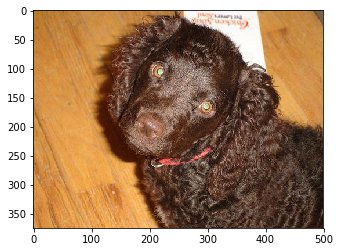

In [35]:
image_detector('images/American_water_spaniel_00648.jpg')



Hello Human
You Look Like a..
Basenji


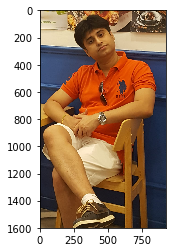

In [36]:
image_detector('images/me.jpg')

Hello Human
You Look Like a..
German_shorthaired_pointer


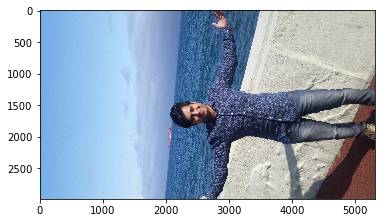

In [56]:
image_detector('images/me1.jpg')

Hello Dog!
Your Predicted Breed is...
Curly-coated_retriever


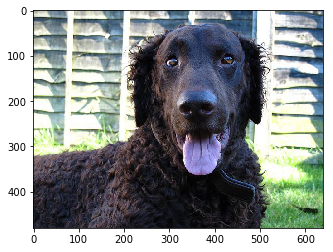

In [55]:
image_detector('images/Curly-coated_retriever_03896.jpg')

Your supplied image neither resembled to a human nor a dog


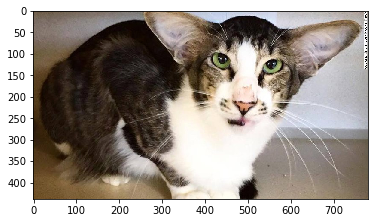

In [48]:
image_detector('images/grumpy-cat.jpg')

Hello Dog!
Your Predicted Breed is...
Belgian_sheepdog


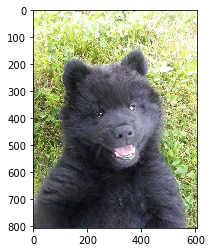

In [39]:
image_detector('images/dog-like-beer.jpg')

Hello Dog!
Your Predicted Breed is...
Chow_chow


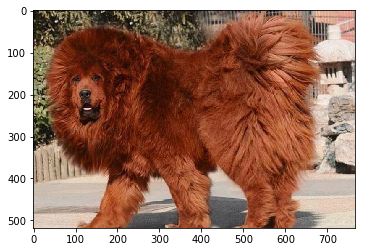

In [41]:
image_detector('images/Tibetan-Mastiff-Worlds-Most-Expensive-Dog.jpg')

Hello Human
You Look Like a..
English_springer_spaniel


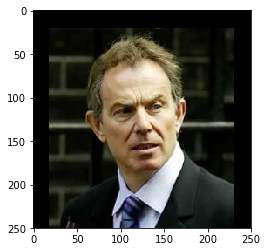

In [122]:
image_detector(human_files_short[89])

Your supplied image neither resembled to a human nor a dog


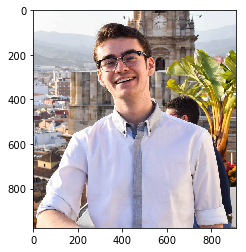

In [50]:
image_detector('images/friend.jpeg')


Hello Human
You Look Like a..
Chihuahua


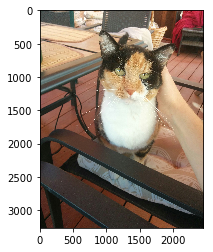

In [45]:
image_detector('images/cat_human.jpeg')


Hello Human
You Look Like a..
Chihuahua


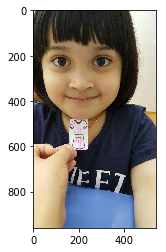

In [52]:
image_detector('images/daughter1.jpg')


Hello Human
You Look Like a..
Basenji


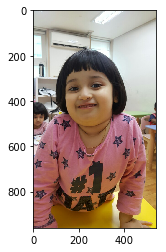

In [53]:
image_detector('images/daughter2.jpg')